# Compliance Diagnostics and IV Validity

**Chapter 9, Section 4**

This notebook covers how to assess the validity of IV/LATE assumptions: first stage strength, exclusion restriction, monotonicity, and complier characterization.

## Table of Contents
1. [Intuition](#intuition) - What can go wrong
2. [Formal Treatment](#formal) - Testing assumptions
3. [Numeric Demonstration](#numeric) - Push notification diagnostics
4. [Implementation](#implementation) - Diagnostic functions
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from linearmodels.iv import IV2SLS

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Four IV Assumptions

LATE identification requires four assumptions. Here's how we can assess each:

| Assumption | Can Test? | How to Assess |
|------------|-----------|---------------|
| **Independence** | Partially | Balance checks, randomization protocol |
| **Exclusion Restriction** | **No** | Theoretical argument, design |
| **First Stage** | **Yes** | F-statistic, coefficient significance |
| **Monotonicity** | Partially | Sign of first stage, domain knowledge |

**Key insight**: The exclusion restriction is **untestable**. It must be argued from the study design and domain knowledge.

---

In [2]:
# Load push notification data
push = load_facure_data("app_engagement_push.csv")

print(f"Data: {len(push):,} users")
push.head()

Data: 10,000 users


,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


---

## Formal Treatment

### 1. First Stage Strength

The **first stage F-statistic** tests whether the instrument predicts treatment.

**Stock-Yogo Rule**: F > 10 indicates a "strong" instrument.

**Why it matters**: Weak instruments cause:
- Large bias in IV estimates (toward OLS)
- Standard errors that understate true uncertainty
- Unreliable confidence intervals

In [3]:
# First stage regression
first_stage = smf.ols('push_delivered ~ push_assigned', data=push).fit()

print("FIRST STAGE DIAGNOSTICS")
print("=" * 55)
print(f"\nFirst Stage Equation: D = a + b*Z")
print(f"  Intercept: {first_stage.params['Intercept']:.4f}")
print(f"  Coefficient (b): {first_stage.params['push_assigned']:.4f}")
print(f"  t-statistic: {first_stage.tvalues['push_assigned']:.1f}")
print(f"  p-value: {first_stage.pvalues['push_assigned']:.2e}")
print(f"\nF-statistic: {first_stage.fvalue:.1f}")
print(f"R-squared: {first_stage.rsquared:.4f}")
print(f"\nStock-Yogo criterion: F > 10")
print(f"Result: {first_stage.fvalue:.1f} >> 10  -  STRONG INSTRUMENT")

FIRST STAGE DIAGNOSTICS

First Stage Equation: D = a + b*Z
  Intercept: -0.0000
  Coefficient (b): 0.7176
  t-statistic: 113.3
  p-value: 0.00e+00

F-statistic: 12846.4
R-squared: 0.5623

Stock-Yogo criterion: F > 10
Result: 12846.4 >> 10  -  STRONG INSTRUMENT


### 2. Exclusion Restriction

The **exclusion restriction** states that Z affects Y **only through D**:

$$Y(z, d) = Y(d) \quad \forall z$$

**Cannot be tested directly**. Must be argued from:
- Study design (randomization)
- Domain knowledge (no direct path Z → Y)
- Theoretical reasoning

**In push notification example**:
- Z = random assignment to receive push
- Assignment itself doesn't cause purchases
- Only the actual push delivery (D) can affect behavior
- ✓ Exclusion plausible by design

In [4]:
# Exclusion restriction assessment
print("EXCLUSION RESTRICTION ASSESSMENT")
print("=" * 55)
print("\nQuestion: Does assignment (Z) affect purchases (Y) except through delivery (D)?")
print("\nPotential violations:")
print("  1. Assignment itself signals something to users (unlikely - they don't know)")
print("  2. Assignment correlates with other interventions (check design)")
print("  3. Assignment measured with error (unlikely in digital experiment)")
print("\nConclusion: In a well-designed RCT, exclusion is plausible by construction.")
print("  - Users don't know their assignment status")
print("  - Assignment is purely random")
print("  - Only the push itself can affect behavior")

EXCLUSION RESTRICTION ASSESSMENT

Question: Does assignment (Z) affect purchases (Y) except through delivery (D)?

Potential violations:
  1. Assignment itself signals something to users (unlikely - they don't know)
  2. Assignment correlates with other interventions (check design)
  3. Assignment measured with error (unlikely in digital experiment)

Conclusion: In a well-designed RCT, exclusion is plausible by construction.
  - Users don't know their assignment status
  - Assignment is purely random
  - Only the push itself can affect behavior


### 3. Monotonicity

**Monotonicity** requires that the instrument affects treatment in the same direction for everyone:

$$D_i(1) \geq D_i(0) \quad \forall i \quad (\text{no defiers})$$

**How to assess**:
1. Sign of first stage coefficient (should be positive for "encouragement" design)
2. Domain knowledge: Are defiers plausible?
3. Check for negative first stage in subgroups

In [5]:
# Monotonicity assessment
print("MONOTONICITY ASSESSMENT")
print("=" * 55)

# Check first stage sign
fs_coef = first_stage.params['push_assigned']
print(f"\nFirst stage coefficient: {fs_coef:.4f}")
print(f"Sign: {'Positive' if fs_coef > 0 else 'Negative'} (suggests no defiers on average)")

# Compliance rates
p_d1_z1 = push.loc[push['push_assigned']==1, 'push_delivered'].mean()
p_d1_z0 = push.loc[push['push_assigned']==0, 'push_delivered'].mean()

print(f"\nCompliance rates:")
print(f"  P(D=1 | Z=1) = {p_d1_z1:.3f}")
print(f"  P(D=1 | Z=0) = {p_d1_z0:.3f}")
print(f"  Difference: {p_d1_z1 - p_d1_z0:.3f} (positive = monotonicity supported)")

print(f"\nDomain knowledge:")
print(f"  - Can users receive push WITHOUT being assigned? No (system controlled)")
print(f"  - Would anyone avoid push IF assigned, but seek it IF not assigned? No")
print(f"  - Defiers are implausible in this design")

MONOTONICITY ASSESSMENT

First stage coefficient: 0.7176
Sign: Positive (suggests no defiers on average)

Compliance rates:
  P(D=1 | Z=1) = 0.718
  P(D=1 | Z=0) = 0.000
  Difference: 0.718 (positive = monotonicity supported)

Domain knowledge:
  - Can users receive push WITHOUT being assigned? No (system controlled)
  - Would anyone avoid push IF assigned, but seek it IF not assigned? No
  - Defiers are implausible in this design


### 4. Independence (Balance)

**Independence** requires that the instrument is as good as randomly assigned:

$$(Y(1), Y(0), D(1), D(0)) \perp Z$$

**How to assess**:
- Balance checks: Compare pre-treatment covariates by Z
- Randomization protocol review
- Placebo tests (if available)

In [6]:
# Independence assessment via balance (if we had covariates)
print("INDEPENDENCE ASSESSMENT")
print("=" * 55)

# Check balance on observable characteristics
# In this dataset, we only have outcomes, so we check randomization design

# Assignment rate should be ~50% if random
assignment_rate = push['push_assigned'].mean()
print(f"\nAssignment rate: {assignment_rate:.1%} (expected: 50%)")

# Sample size balance
n_assigned = push['push_assigned'].sum()
n_not_assigned = len(push) - n_assigned
print(f"\nSample sizes:")
print(f"  Assigned (Z=1): n = {n_assigned:,}")
print(f"  Not assigned (Z=0): n = {n_not_assigned:,}")
print(f"  Balance: {min(n_assigned, n_not_assigned)/max(n_assigned, n_not_assigned):.1%}")

print(f"\nConclusion: Assignment appears random by design (RCT).")

INDEPENDENCE ASSESSMENT

Assignment rate: 49.4% (expected: 50%)

Sample sizes:
  Assigned (Z=1): n = 4,943
  Not assigned (Z=0): n = 5,057
  Balance: 97.7%

Conclusion: Assignment appears random by design (RCT).


---

## Numeric Demonstration

### Complete IV Diagnostics

In [7]:
# Full IV estimation with diagnostics
iv_result = IV2SLS.from_formula(
    'in_app_purchase ~ 1 + [push_delivered ~ push_assigned]',
    data=push
).fit()

print("IV ESTIMATION RESULTS")
print("=" * 55)
print(f"\nLATE Estimate: ${iv_result.params['push_delivered']:.2f}")
print(f"Standard Error: {iv_result.std_errors['push_delivered']:.2f}")
print(f"95% CI: [${iv_result.params['push_delivered'] - 1.96*iv_result.std_errors['push_delivered']:.2f}, ${iv_result.params['push_delivered'] + 1.96*iv_result.std_errors['push_delivered']:.2f}]")
print(f"p-value: {iv_result.pvalues['push_delivered']:.4f}")

IV ESTIMATION RESULTS

LATE Estimate: $3.29
Standard Error: 0.72
95% CI: [$1.89, $4.70]
p-value: 0.0000


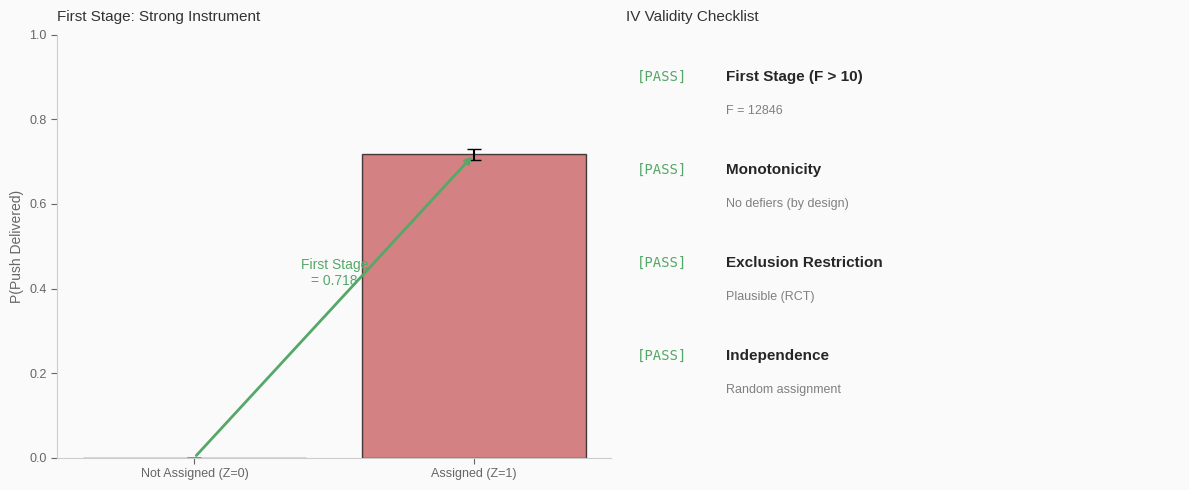

In [8]:
# Visualize diagnostic summary
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: First stage visualization
ax = axes[0]

# Delivery rates by assignment
groups = push.groupby('push_assigned')['push_delivered'].agg(['mean', 'std', 'count'])
x = [0, 1]
means = groups['mean'].values
ses = groups['std'].values / np.sqrt(groups['count'].values)

ax.bar(x, means, color=[COLORS['blue'], COLORS['red']], alpha=0.7, edgecolor='black')
ax.errorbar(x, means, yerr=1.96*ses, fmt='none', color='black', capsize=5)

# Annotate first stage
ax.annotate('', xy=(1, means[1]), xytext=(0, means[0]),
            arrowprops=dict(arrowstyle='->', color=COLORS['green'], lw=2))
ax.text(0.5, (means[0]+means[1])/2 + 0.05, f'First Stage\n= {means[1]-means[0]:.3f}', 
        ha='center', fontsize=10, color=COLORS['green'])

ax.set_xticks(x)
ax.set_xticklabels(['Not Assigned (Z=0)', 'Assigned (Z=1)'])
ax.set_ylim(0, 1)
set_tufte_title(ax, "First Stage: Strong Instrument")
set_tufte_labels(ax, "", "P(Push Delivered)")

# Right: Diagnostic checklist
ax = axes[1]
ax.axis('off')

checklist = [
    ("First Stage (F > 10)", f"F = {first_stage.fvalue:.0f}", True),
    ("Monotonicity", "No defiers (by design)", True),
    ("Exclusion Restriction", "Plausible (RCT)", True),
    ("Independence", "Random assignment", True),
]

y_pos = 0.9
for check, detail, passed in checklist:
    symbol = '[PASS]' if passed else '[FAIL]'
    color = COLORS['green'] if passed else COLORS['red']
    ax.text(0.02, y_pos, symbol, fontsize=10, color=color, va='center', fontfamily='monospace')
    ax.text(0.18, y_pos, check, fontsize=11, va='center', fontweight='bold')
    ax.text(0.18, y_pos - 0.08, detail, fontsize=9, va='center', color='gray')
    y_pos -= 0.22

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
set_tufte_title(ax, "IV Validity Checklist")

plt.tight_layout()
plt.show()

### Who Are the Compliers?

LATE applies only to compliers. Understanding **who they are** is crucial for external validity.

In [9]:
# Characterizing compliers
print("COMPLIER CHARACTERIZATION")
print("=" * 55)

# What we know:
pi_c = p_d1_z1 - p_d1_z0  # Complier proportion
pi_nt = 1 - p_d1_z1  # Never-taker proportion
pi_at = p_d1_z0  # Always-taker proportion

print(f"\nStratum Proportions:")
print(f"  Compliers: {pi_c:.1%}")
print(f"  Never-takers: {pi_nt:.1%}")
print(f"  Always-takers: {pi_at:.1%}")

print(f"\nWho are the compliers?")
print(f"  - Users whose phones CAN receive the fancy push notification")
print(f"  - Likely have NEWER phones")
print(f"  - Newer phones correlate with higher income")
print(f"  - Higher income may correlate with different purchase patterns")

print(f"\nWho are the never-takers?")
print(f"  - Users whose phones CANNOT receive the push")
print(f"  - Likely have OLDER phones")
print(f"  - May be lower income segment")
print(f"  - Treatment effect for them is UNKNOWN")

print(f"\nExternal Validity Concern:")
print(f"  LATE of ${iv_result.params['push_delivered']:.2f} applies to compliers (newer phone users).")
print(f"  Cannot generalize to never-takers without additional assumptions.")

COMPLIER CHARACTERIZATION

Stratum Proportions:
  Compliers: 71.8%
  Never-takers: 28.2%
  Always-takers: 0.0%

Who are the compliers?
  - Users whose phones CAN receive the fancy push notification
  - Likely have NEWER phones
  - Newer phones correlate with higher income
  - Higher income may correlate with different purchase patterns

Who are the never-takers?
  - Users whose phones CANNOT receive the push
  - Likely have OLDER phones
  - May be lower income segment
  - Treatment effect for them is UNKNOWN

External Validity Concern:
  LATE of $3.29 applies to compliers (newer phone users).
  Cannot generalize to never-takers without additional assumptions.


---

## Implementation

### Comprehensive IV Diagnostics Function

In [10]:
def iv_diagnostics(df, outcome, treatment, instrument):
    """
    Comprehensive IV diagnostics for LATE estimation.
    
    Parameters
    ----------
    df : pd.DataFrame
    outcome, treatment, instrument : str
        Column names for Y, D, Z.
        
    Returns
    -------
    dict
        Diagnostic results and recommendations.
    """
    Y = df[outcome]
    D = df[treatment]
    Z = df[instrument]
    
    # First stage
    fs_model = smf.ols(f'{treatment} ~ {instrument}', data=df).fit()
    fs_coef = fs_model.params[instrument]
    fs_f = fs_model.fvalue
    fs_p = fs_model.pvalues[instrument]
    
    # Reduced form
    rf_model = smf.ols(f'{outcome} ~ {instrument}', data=df).fit()
    rf_coef = rf_model.params[instrument]
    
    # Compliance rates
    p_d1_z1 = D[Z == 1].mean()
    p_d1_z0 = D[Z == 0].mean()
    
    # Stratum proportions (under monotonicity)
    pi_compliers = p_d1_z1 - p_d1_z0
    pi_always_takers = p_d1_z0
    pi_never_takers = 1 - p_d1_z1
    
    # LATE estimate
    late = rf_coef / fs_coef if abs(fs_coef) > 1e-10 else np.nan
    
    # Diagnostics
    strong_instrument = fs_f > 10
    monotonicity_plausible = fs_coef > 0  # Positive first stage
    
    return {
        'first_stage_coef': fs_coef,
        'first_stage_f': fs_f,
        'first_stage_p': fs_p,
        'reduced_form_coef': rf_coef,
        'late_estimate': late,
        'pi_compliers': pi_compliers,
        'pi_always_takers': pi_always_takers,
        'pi_never_takers': pi_never_takers,
        'strong_instrument': strong_instrument,
        'monotonicity_plausible': monotonicity_plausible,
        'recommendation': 'Valid IV' if (strong_instrument and monotonicity_plausible) else 'Check assumptions'
    }

# Run diagnostics
diag = iv_diagnostics(push, 'in_app_purchase', 'push_delivered', 'push_assigned')

print("IV DIAGNOSTICS SUMMARY")
print("=" * 55)
for k, v in diag.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

IV DIAGNOSTICS SUMMARY
  first_stage_coef: 0.7176
  first_stage_f: 12846.4123
  first_stage_p: 0.0000
  reduced_form_coef: 2.3636
  late_estimate: 3.2938
  pi_compliers: 0.7176
  pi_always_takers: 0.0000
  pi_never_takers: 0.2824
  strong_instrument: True
  monotonicity_plausible: True
  recommendation: Valid IV


---

## Interview Appendix

### Practice Questions

**Q1: How do you assess IV validity in practice?**

<details>
<summary>Solution</summary>

| Assumption | Assessment Method |
|------------|------------------|
| **First Stage** | F-statistic > 10 (testable) |
| **Exclusion** | Theoretical argument, design (untestable) |
| **Monotonicity** | Sign of first stage, domain knowledge |
| **Independence** | Balance checks, randomization protocol |

**Key insight**: The exclusion restriction cannot be tested empirically. It must be argued based on:
- Study design (randomization breaks confounding paths)
- Domain knowledge (no direct Z → Y path)
- Theoretical reasoning (why would Z affect Y except through D?)

</details>

**Q2: What happens with a weak instrument?**

<details>
<summary>Solution</summary>

**Weak instruments** (F < 10) cause:

1. **Bias**: IV estimates are biased toward OLS
   - In finite samples, weak IV ~ biased OLS
   - The weaker the instrument, the closer to OLS bias

2. **Unreliable inference**: 
   - Standard errors understate true uncertainty
   - Confidence intervals have incorrect coverage
   - t-tests have wrong size (too many rejections)

3. **Instability**: Small changes in data → large changes in estimates

**Solutions**:
- Use stronger instruments
- LIML instead of 2SLS (less biased with weak instruments)
- Anderson-Rubin confidence intervals (robust to weak IV)

</details>

**Q3: Why can't we test the exclusion restriction?**

<details>
<summary>Solution</summary>

The **exclusion restriction** states: $Y(z,d) = Y(d)$ (Z affects Y only through D).

**Why untestable**: We never observe what Y would be under different Z values holding D fixed. The exclusion is about **counterfactual** outcomes.

**What we CAN do**:
1. Argue from design (randomization eliminates direct paths)
2. Check placebo outcomes (outcomes Z shouldn't affect)
3. Use overidentification tests (if multiple instruments)
4. Sensitivity analysis (what if small direct effect?)

**Key insight**: IV credibility ultimately rests on theoretical arguments, not statistical tests. This is why study design is crucial.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 9.

[^2]: Stock, J. H., & Yogo, M. (2005). Testing for weak instruments in linear IV regression. In *Identification and Inference for Econometric Models*.

[^3]: Cross-reference: Weak instruments in `08_instrumental_variables/04_weak_instruments.ipynb`